In [1]:
import cv2
import numpy as np
import h5py
from collections import defaultdict
from scipy.spatial.transform import Rotation

import os
from pprint import pprint
import gc
# import open3d as o3d
import matplotlib.pyplot as plt
from PIL import Image
import threading
from tqdm import tqdm

In [2]:
def estimate_pose(kpts0, kpts1, K0, K1, thresh, conf=0.99999):
    if len(kpts0) < 5:
        return None

    f_mean = np.mean([K0[0, 0], K1[1, 1], K0[0, 0], K1[1, 1]])
    norm_thresh = thresh / f_mean

    kpts0 = (kpts0 - K0[[0, 1], [2, 2]][None]) / K0[[0, 1], [0, 1]][None]
    kpts1 = (kpts1 - K1[[0, 1], [2, 2]][None]) / K1[[0, 1], [0, 1]][None]

    E, mask = cv2.findEssentialMat(
        kpts0, kpts1, np.eye(3), threshold=norm_thresh, prob=conf,
        method=cv2.USAC_MAGSAC)

    if E is None:
        return None

    best_num_inliers = 0
    ret = None
    for _E in np.split(E, len(E) / 3):
        n, R, t, _ = cv2.recoverPose(
            _E, kpts0, kpts1, np.eye(3), 1e9, mask=mask)
        if n > best_num_inliers:
            best_num_inliers = n
            ret = (R, t[:, 0], mask.ravel() > 0)
    return ret


def angle_error_mat(R1, R2):
    cos = (np.trace(np.dot(R1.T, R2)) - 1) / 2
    cos = np.clip(cos, -1., 1.)  # numercial errors can make it out of bounds
    return np.rad2deg(np.abs(np.arccos(cos)))


def angle_error_vec(v1, v2):
    n = np.linalg.norm(v1) * np.linalg.norm(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1, v2) / n, -1.0, 1.0)))


def compute_pose_error(T_0to1, est_pose):
    R_gt = T_0to1[:3, :3]
    t_gt = T_0to1[:3, 3]
    R = est_pose[:3, :3]
    t = est_pose[:3, 3]
    error_t = angle_error_vec(t, t_gt)
    error_t = np.minimum(error_t, 180 - error_t)  # ambiguity of E estimation
    error_R = angle_error_mat(R, R_gt)
    return error_t, error_R

In [3]:
def load_retrieval_pairs(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        pairs = []
        for line in f:
            pair = line.strip().split(" ")
            pairs.append(pair)
    f.close()
    return pairs

def load_images(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        images = defaultdict(dict)
        for line in f:
            if line.startswith("#"): continue
            timestamp, sensor_id, image_path = line.strip().split(", ")
            images[image_path] = {
                "timestamp": timestamp,
                "sensor_id": sensor_id
            }
    return images

def load_intrinsics(file_path):
    sensors = defaultdict(dict)
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith("#"): continue
            line = line.strip().split(", ")
            if len(line) < 6: continue
            
            sensor_id = line[0]
            width, height = line[4:6]
            fx, fy, cx, cy = line[6:]
            K = np.array([
                [fx, 0, cx],
                [0, fy, cy],
                [0, 0, 1],
            ], dtype=float)
            
            sensors[sensor_id] = {
                'K': K,
                'width': int(width),
                'height': int(height),
            }
    return sensors

def load_rigs(file_path):
    if file_path is None:
        q = {'x': 0.0, 'y': 0.0, 'z': 0.0, 'w': 1.0}    # No rotate
        t = {'x': 0.0, 'y': 0.0, 'z': 0.0}              # No translate
        q_xyzw = np.array([q['x'], q['y'], q['z'], q['w']])
        Q = Rotation.from_quat(q_xyzw).as_matrix()
        T = np.array([t['x'], t['y'], t['z']])
        
        cam2rig = np.eye(4)
        cam2rig[:3, :3] = Q
        cam2rig[:3, 3] = T
        
        return {
            'rig_sensors': {
                'cam2rig': cam2rig,
            }
        }
        
    rigs = defaultdict(dict)
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith("#"): continue
            line = line.strip().split(", ")
            
            # rig_id = line[0].split("_")[-1]
            # sensor_id = line[1].split("/")[-1]
            
            rig_id = line[0]
            sensor_id = line[1]
            q = {
                'w': float(line[2]),
                'x': float(line[3]),
                'y': float(line[4]),
                'z': float(line[5]),
            }
            t = {
                'x': float(line[6]),
                'y': float(line[7]),
                'z': float(line[8]),
            }
            
            q_xyzw = np.array([q['x'], q['y'], q['z'], q['w']])
            Q = Rotation.from_quat(q_xyzw).as_matrix()
            T = np.array([t['x'], t['y'], t['z']])
            
            cam2rig = np.eye(4)
            cam2rig[:3, :3] = Q
            cam2rig[:3, 3] = T
            
            rigs[rig_id][sensor_id] = {
                'cam2rig': cam2rig,
            }
    return rigs

def load_poses(file_path):
    poses = defaultdict(dict)
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith("#"): continue
            line = line.strip().split(", ")
            timestamp = line[0]
            device_id = line[1]
            
            q = {
                'w': float(line[2]),
                'x': float(line[3]),
                'y': float(line[4]),
                'z': float(line[5]),
            }
            t = {
                'x': float(line[6]),
                'y': float(line[7]),
                'z': float(line[8]),
            }
            
            q_xyzw = np.array([q['x'], q['y'], q['z'], q['w']])
            Q = Rotation.from_quat(q_xyzw).as_matrix()
            T = np.array([t['x'], t['y'], t['z']])
            pose = np.eye(4)
            pose[:3, :3] = Q
            pose[:3, 3] = T
            poses[timestamp] = {
                'pose': pose,
                'device_id': device_id
            }
    return poses

def load_keypoints(file_path):
    """
    Load keypoints and descriptors from H5 file.
    
    Supports two structures:
    
    Structure 1 (ios_query):
    - {session}/raw_data/{subsession}/images/{image_id}/
      - keypoints, descriptors, scores, image_size
    
    Structure 2 (spot_query):
    - {session}/raw_data/{subsession}/{camera}/{image_id}/
      - keypoints, descriptors, scores, image_size
    
    Structure 3 (hl_query):
    - {session}/raw_data/{subsession}/images/{camera}/{image_id}/
      - keypoints, descriptors, scores, image_size
    
    Returns nested dicts with flexible structure based on hierarchy depth.
    """
    
    results = defaultdict(dict)
    
    def recursive_load(group, result_key):
        """
        Recursively traverse H5 group and load data when keypoints are found.
        """
        # Check if this group contains keypoints (leaf node)
        if 'keypoints' in group:
            keypoints = np.array(group['keypoints'][:], dtype=np.int32)
            descriptors = np.array(group['descriptors'][:], dtype=np.float32)
            scores = np.array(group['scores'][:], dtype=np.float32)
            image_size = np.array(group['image_size'][:], dtype=np.int32)
            
            results[result_key]['keypoints'] = keypoints
            results[result_key]['descriptors'] = descriptors
            results[result_key]['scores'] = scores
            results[result_key]['image_size'] = image_size
            return
        
        # If not leaf node, iterate through children
        for key in group.keys():
            item = group[key]
            if isinstance(item, h5py.Group):
                # Recurse into this group
                recursive_load(item, f"{result_key}{'/' if result_key != '' else ''}{key}")
    
    with h5py.File(file_path, 'r') as f:
        recursive_load(f, result_key="")
    
    return results

def load_matches(file_path):
    """
    Load matching results from H5 file.
    
    Structure:
    - Group for each query image
      - Group for each map image
        - matches0: matched indices in map image (-1 means no match)
        - matching_scores0: confidence scores for matches
    """
    
    results = defaultdict(dict)
    
    def recursive_load(group, result_key):
        """
        Recursively traverse H5 group and load data when keypoints are found.
        """
        # Check if this group contains keypoints (leaf node)
        if 'matches0' in group:
            matches = np.array(group['matches0'][:], dtype=np.int32)
            scores = np.array(group['matching_scores0'][:], dtype=np.float32)
            
            results[result_key]['matches0'] = matches
            results[result_key]['matching_scores0'] = scores
            return
        
        # If not leaf node, iterate through children
        for key in group.keys():
            item = group[key]
            if isinstance(item, h5py.Group):
                # Recurse into this group
                recursive_load(item, f"{result_key} {key}" if result_key != "" else key)
    
    with h5py.File(file_path, 'r') as f:
        recursive_load(f, result_key="")
    
    return results

In [4]:
# query_device = 'ios'
# map_device = 'ios'

# MATCHES_PATH = f"/home/long/Workspace/crocodl-benchmark/capture/ARCHE_D2/long/benchmarking_results/matching/{query_device}_query/{map_device}_map/superpoint/lightglue/matches.h5"
# all_matches = load_matches(MATCHES_PATH)

In [5]:
# all_matches['ios_query-raw_data-ios_2023-07-12_20.46.14_000-images-4793970038.jpg ios_map-raw_data-ios_2023-07-12_20.46.14_002-images-5008076867.jpg']['matching_scores0'].mean()

In [6]:
# scores = [v['matching_scores0'].mean() for k, v in all_matches.items()]
# sorted(scores, reverse=True)

In [7]:
def get_K(Ks, images, image):
    sensor_id = images[image]['sensor_id']
    return Ks[sensor_id]['K']

def get_device_id(query_img, timestamp, query_device):
    query_img = query_img.split("/")
    sub = query_img[0]
    
    if query_device == "ios":
        query_device = f"{sub}/cam_phone_{timestamp}"
    if query_device == "hl":
        query_device = f"{sub}/hetrig_{timestamp}"
    if query_device == "spot":
        query_device = f"{sub}/{timestamp}-body"
    
    return query_device

def estimate_poses(pairs, all_matches, all_kpts0, all_kpts1, query_images, map_images, query_Ks, map_Ks):
    est_poses = {}
    for query_img, map_img in pairs:
        query_device = query_img.split("_")[0]
        
        # Matches
        matches, _ = all_matches[f"{query_img.replace('/', '-')} {map_img.replace('/', '-')}"].values()

        # Keypoints
        kpts0 = all_kpts0[query_img]['keypoints']
        kpts1 = all_kpts1[map_img]['keypoints']
            
        # Keep the matching keypoints.
        valid = matches > -1
        mkpts0 = kpts0[valid]
        mkpts1 = kpts1[matches[valid]]

        # Estimate the pose and compute the pose error.
        query_img = "/".join(query_img.split("/")[2:])
        map_img = "/".join(map_img.split("/")[2:])
        
        K0 = get_K(query_Ks, query_images, query_img)
        K1 = get_K(map_Ks, map_images, map_img)

        thresh = 1.  # In pixels relative to resized image size.
        est_pose = estimate_pose(mkpts0, mkpts1, K0, K1, thresh)
        if est_pose is None: continue
                
        query_timestamp = query_images[query_img]['timestamp']
        map_timestamp = map_images[map_img]['timestamp']
        est_poses[f"{query_timestamp}-{map_timestamp}"] = {
            "pose": est_pose,
            "device_id": get_device_id(query_img, query_timestamp, query_device)
        }
    return est_poses

def compute_errors(pairs, query_images, map_images, est_poses, query_poses, map_poses, query_rigs, map_rigs, top, Rt_threshold, r_margin, all_matches):    
    all_err_t, all_err_R = defaultdict(list), defaultdict(list)
    good_pairs, bad_pairs = [], []
    err_Rs, scores = [], []
    for query_img, map_img in pairs:
        #######################################
        _, matching_score = all_matches[f"{query_img.replace('/', '-')} {map_img.replace('/', '-')}"].values()
        matching_score = np.mean(matching_score)
        #######################################
        
        query_img = "/".join(query_img.split("/")[2:])
        map_img = "/".join(map_img.split("/")[2:])
        query_timestamp, query_sensor = query_images[query_img]['timestamp'],  query_images[query_img]['sensor_id']
        map_timestamp, map_sensor = map_images[map_img]['timestamp'],  map_images[map_img]['sensor_id']
        
        if f"{query_timestamp}-{map_timestamp}" not in est_poses: continue
        
        est_pose = est_poses[f"{query_timestamp}-{map_timestamp}"]['pose']
        
        query_pose = get_groundtruth(query_poses, query_rigs, query_timestamp, query_sensor)
        map_pose = get_groundtruth(map_poses, map_rigs, map_timestamp, map_sensor)
        
        # Relative
        T_0to1 = np.linalg.inv(map_pose) @ query_pose
        
        try:
            err_t, err_R = compute_pose_error(T_0to1, est_pose)
        except Exception as e:
            print(est_pose)
            print(e)
        
        # Collect
        all_err_t[query_img].append(err_t)
        all_err_R[query_img].append(err_R)
        
        # Classify
        if err_R < r_margin:
            good_pairs.append((query_img, map_img, str(err_R), str(matching_score)))
        else:
            bad_pairs.append((query_img, map_img, str(err_R), str(matching_score)))
        
        #######################################
        err_Rs.append(err_R)
        scores.append(matching_score)
        #######################################
    
    all_err_t = convert_to_list(all_err_t, top)
    all_err_R = convert_to_list(all_err_R, top)
    
    th_r, th_t = Rt_threshold
    recall = np.mean((all_err_R < th_r) & (all_err_t < th_t))
    return all_err_t.mean(), all_err_R.mean(), recall, good_pairs, bad_pairs, err_Rs, scores

def save_est_poses(file_path, est_poses):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with open(file_path, 'w', encoding='utf-8') as f:
        lines = ""
        lines += "# timestamp, device_id, qw, qx, qy, qz, tx, ty, tz, *covar\n"
        for timestamp, data in est_poses.items():
            line = [timestamp]
            line.append(data['device_id'])
            q_xyzw, t = get_q_t(data['pose'])
            line.append(str(q_xyzw[3]))
            line.append(str(q_xyzw[0]))
            line.append(str(q_xyzw[1]))
            line.append(str(q_xyzw[2]))
            line.append(str(t[0]))
            line.append(str(t[1]))
            line.append(str(t[2]))
            lines += ", ".join(line) + "\n"
        f.write(lines)
    f.close()
    print(f"Saved estimated poses to {file_path}")

def get_q_t(pose):
    Q, T, _ = pose
    r = Rotation.from_matrix(Q)
    q_xyzw = r.as_quat()
    t = T
    return q_xyzw, t
    
def get_groundtruth(poses, rigs, timestamp, cam):
    rig2world = poses[timestamp]['pose']
    rig_id = poses[timestamp]['device_id']
    
    if "rig_sensors" in rigs.keys():
        cam2rig = rigs["rig_sensors"]['cam2rig']
    else:
        cam2rig = rigs[rig_id][cam]['cam2rig']
    
    return rig2world @ cam2rig

def filter_top(results, n=5):
    for k, v in results.items():
        results[k] = sorted(v)[:n]
    return results

def convert_to_list(results, top=5):
    results = filter_top(results, top)
    result_list = []
    for value_list in results.values():
        result_list.extend(value_list)
    return np.array(result_list)

def save_pairs(pairs, save_dir, type, extra_cols=['R_err']):
    save_path = f"{save_dir}/{type}_pairs.txt"
    with open(save_path, 'w', encoding='utf-8') as f:
        last_cols = ', '.join(extra_cols)   
        lines = f"# query_img, map_img, {last_cols}"
        for pair in pairs:
            line = ", ".join(pair)
            lines += line + '\n'
        f.write(lines)
    print(f"Saved {type} pairs to {save_path}")
    f.close()

In [8]:
capture = "/home/long/Workspace/crocodl-benchmark/capture"

def evaluate_pair(query_device, map_device, top, Rt_threshold, r_margin):
    # Pairs
    PAIRS_PATH = f"{capture}/ARCHE_D2/long/benchmarking_results/pair_selection/{query_device}_query/{map_device}_map/megaloc/pairs.txt"
    pairs = load_retrieval_pairs(PAIRS_PATH)

    # Images
    QUERY_IMAGES_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/images.txt"
    MAP_IMAGES_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/images.txt"
    query_images = load_images(QUERY_IMAGES_PATH)
    map_images = load_images(MAP_IMAGES_PATH)
    
    SAVE_DIR = f"estimate_pose/{query_device}_query/{map_device}_map"
    SAVE_PATH = f"{SAVE_DIR}/est_poses.txt"
    
    if not os.path.exists(SAVE_PATH):
        # Keypoints
        KPTS0_PATH = f"{capture}/ARCHE_D2/long/benchmarking_results/extraction/{query_device}_query/superpoint/features.h5"
        all_kpts0 = load_keypoints(KPTS0_PATH)
        KPTS1_PATH = f"{capture}/ARCHE_D2/long/benchmarking_results/extraction/{map_device}_map/superpoint/features.h5"
        all_kpts1 = load_keypoints(KPTS1_PATH)

        # Matches
        MATCHES_PATH = f"{capture}/ARCHE_D2/long/benchmarking_results/matching/{query_device}_query/{map_device}_map/superpoint/lightglue/matches.h5"
        all_matches = load_matches(MATCHES_PATH)

        # Intrinsics
        QUERY_SENSORS_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/sensors.txt"
        MAP_SENSORS_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/sensors.txt"
        query_Ks = load_intrinsics(QUERY_SENSORS_PATH)
        map_Ks = load_intrinsics(MAP_SENSORS_PATH)
        
        est_poses = estimate_poses(pairs, all_matches, all_kpts0, all_kpts1, query_images, map_images, query_Ks, map_Ks)
        save_est_poses(SAVE_PATH, est_poses)
        est_poses = load_poses(SAVE_PATH)
    else:
        #######################################
        MATCHES_PATH = f"{capture}/ARCHE_D2/long/benchmarking_results/matching/{query_device}_query/{map_device}_map/superpoint/lightglue/matches.h5"
        all_matches = load_matches(MATCHES_PATH)
        #######################################
        est_poses = load_poses(SAVE_PATH)
        
    # Poses
    QUERY_POSES_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/proc/alignment_trajectories.txt"
    MAP_POSES_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/trajectories.txt"
    query_poses = load_poses(QUERY_POSES_PATH)
    map_poses = load_poses(MAP_POSES_PATH)

    # Rigs
    QUERY_RIGS_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/rigs.txt" if query_device != "ios" else None
    MAP_RIGS_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/rigs.txt" if map_device != "ios" else None
    query_rigs = load_rigs(QUERY_RIGS_PATH)
    map_rigs = load_rigs(MAP_RIGS_PATH)
        
    all_err_t, all_err_R, recall, good_pairs, bad_pairs, err_Rs, scores = compute_errors(pairs, query_images, map_images, est_poses, query_poses, map_poses, query_rigs, map_rigs, top, Rt_threshold, r_margin, all_matches)
    save_pairs(good_pairs, SAVE_DIR, 'good', extra_cols=['R_err', 'matching_score'])
    save_pairs(bad_pairs, SAVE_DIR, 'bad', extra_cols=['R_err', 'matching_score'])
    gc.collect()
    
    return all_err_t, all_err_R, recall, err_Rs, scores

In [9]:
# QUERY_DEVICES = ["ios", "hl", "spot"]
# MAP_DEVICES = ["ios", "hl", "spot"]

# top = 5
# Rt_threshold = (20.0, 20.0)
# r_margin = 5.0

# results = defaultdict(dict)
# for query_device in QUERY_DEVICES:
#     for map_device in MAP_DEVICES:
#         print(f"{'*'*10} {query_device}-{map_device} (top {top}) {'*'*10}")
#         err_t, err_R, recall, err_Rs, scores = evaluate_pair(query_device, map_device, top, Rt_threshold, r_margin)
#         results[query_device][map_device] = {
#             "err_t": err_t,
#             "err_R": err_R, 
#             "recall": recall
#         }
#         print(f"err_R = {err_R:.4f}")
#         #######################################
#         print(f"simm = {np.dot(err_Rs, scores) / (np.linalg.norm(err_Rs) * np.linalg.norm(scores)):.4f}")
#         #######################################


In [10]:
def show_matrix(results, metric):
    # Get all labels
    labels = list(results.keys())

    # Print header
    print(f"{'':>6}", end=' ')
    for col in labels:
        print(f"{col:>10}", end=' ')
    print()

    # Print rows
    for row in labels:
        print(f"{row:>6}", end=' ')
        for col in labels:
            value = results[row][col][metric]
            print(f"{value:10.4f}", end=' ')
        print()

metric = 'err_R' # err_R, err_t, acc_R, recall
# show_matrix(results, metric)

In [11]:
# !cd ~/Workspace/crocodl-benchmark && export CAPTURE_DIR=./capture && bash ./evaluate/evaluate.sh

In [12]:
        
def show_img_pair(pair, capture, query_device, map_device, metrics=[{'Error': 2}]):
    query_img_path, map_img_path, *_ = pair

    query_img_path = f"{capture}/ARCHE_D2/sessions/{query_device}_query/raw_data/{query_img_path}"
    map_img_path = f"{capture}/ARCHE_D2/sessions/{map_device}_map/raw_data/{map_img_path}"
    
    query_img = Image.open(query_img_path)
    map_img = Image.open(map_img_path)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(query_img)
    axs[0].set_title(f"Query <{query_device}> Image")
    axs[0].axis('off')

    axs[1].imshow(map_img)
    axs[1].set_title(f"Map <{map_device}> Image")
    axs[1].axis('off')

    text = []
    for metric, index in metrics:
        value = float(pair[index])
        text.append(f"{metric}: {value:.4f}")
    text = ' | '.join(text)
    fig.text(0.5, 1, text, ha='center', va='center', fontsize=12, color='red', weight='bold')

    # Show the plot
    plt.tight_layout()
    plt.show()

def load_pairs(file_path, sample=None):
    with open(file_path, 'r', encoding='utf-8') as f:
        pairs = []
        for line in f:
            if line.startswith("#"): continue
            pair = line.strip().split(', ')
            pairs.append(tuple(pair))
        if sample:
            samples = np.random.choice(range(len(pairs)), sample)
            pairs = np.array(pairs)[samples]
        return pairs

In [13]:


    
# def plot_cam_frustum(K, width, height, color=[255, 255, 255], scale=0.1):
#     # 1. Image corner pixel coordinates (in homogeneous form)
#     corners_px = np.array([
#         [0,     0,      1],  # top-left
#         [width, 0,      1],  # top-right
#         [width, height, 1],  # bottom-right
#         [0,     height, 1]   # bottom-left
#     ]).T  # shape (3, 4)

#     # 2. Backproject to normalized 3D rays
#     K_inv = np.linalg.inv(K)
#     rays = K_inv @ corners_px
#     rays /= rays[2, :]  # normalize so z=1
#     rays *= scale       # scale to desired depth

#     # 3. Camera center
#     cam_center = np.zeros((3, 1))  # (3, 1)

#     # 4. All points: cam center + 4 corners
#     points = np.hstack((cam_center, rays))  # shape (3, 5)
#     points = points.T  # shape (5, 3)

#     # 5. Define lines: from center to corners, and corners to each other
#     lines = [
#         [0, 1], [0, 2], [0, 3], [0, 4],  # camera center to corners
#         [1, 2], [2, 3], [3, 4], [4, 1]   # image plane rectangle
#     ]

#     # 6. Colors for each line
#     colors = [color for _ in lines]

#     # 7. Create Open3D LineSet
#     line_set = o3d.geometry.LineSet(
#         points=o3d.utility.Vector3dVector(points),
#         lines=o3d.utility.Vector2iVector(lines)
#     )
#     line_set.colors = o3d.utility.Vector3dVector(colors)

#     return line_set

# def get_T_from_pose_matrix(pose_matrix):
#     return pose_matrix[:3, 3]
    
# def plot_cam(vis, cam_pose, K, w, h, color):
#     frustum = plot_cam_frustum(K, w, h, color)
#     frustum.transform(cam_pose)
#     vis.add_geometry(frustum)
#     return vis

# def visualize_pairs(pair, est_poses, query_poses, map_poses, q_imgs, m_imgs, q_rigs, m_rigs, qKs, mKs):
#     vis = o3d.visualization.Visualizer()
#     query_img, map_img, *_ = pair
#     vis.create_window()
#     # Prepare
#     q_ts, q_sensor = q_imgs[query_img]['timestamp'],  q_imgs[query_img]['sensor_id']
#     m_ts, m_sensor = m_imgs[map_img]['timestamp'],  m_imgs[map_img]['sensor_id']
    
#     if f"{q_ts}-{m_ts}" not in est_poses: return
    
#     est_pose = est_poses[f"{q_ts}-{m_ts}"]['pose']
#     query_pose = get_groundtruth(query_poses, q_rigs, q_ts, q_sensor)
#     map_pose = get_groundtruth(map_poses, m_rigs, m_ts, m_sensor)
    
#     est_pose = map_pose @ est_pose
    
#     qK, qw, qh = qKs[q_sensor].values()
#     mK, mw, mh = mKs[m_sensor].values()
    
#     # Vis cam
#     vis = plot_cam(vis, est_pose, qK, qh, qw, [255, 0, 0])
#     vis = plot_cam(vis, query_pose, qK, qh, qw, [0, 255, 0])
#     vis = plot_cam(vis, map_pose, mK, mh, mw, [0, 0, 255])
    
#     opt = vis.get_render_option()
#     opt.line_width = 10
#     opt.background_color = np.array([0, 0, 0])
#     axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)
#     vis.add_geometry(axis)
#     vis.run()
#     vis.clear_geometries()
#     vis.destroy_window()


# #########################################
# #########################################
# capture = "/home/long/Workspace/crocodl-benchmark/capture"
# query_device = 'ios'
# map_device = 'ios'
# group = 'bad'
# sample = 10

# # Pairs
# PAIRS_PATH = f"estimate_pose/{query_device}_query/{map_device}_map/{group}_pairs.txt"
# pairs = load_pairs(PAIRS_PATH, sample)

# # Images
# QUERY_IMAGES_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/images.txt"
# MAP_IMAGES_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/images.txt"
# q_imgs = load_images(QUERY_IMAGES_PATH)
# m_imgs = load_images(MAP_IMAGES_PATH)

# SAVE_DIR = f"estimate_pose/{query_device}_query/{map_device}_map"
# SAVE_PATH = f"{SAVE_DIR}/est_poses.txt"
# est_poses = load_poses(SAVE_PATH)
    
# # Poses
# QUERY_POSES_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/proc/alignment_trajectories.txt"
# MAP_POSES_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/trajectories.txt"
# query_poses = load_poses(QUERY_POSES_PATH)
# map_poses = load_poses(MAP_POSES_PATH)

# # Rigs
# QUERY_RIGS_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/rigs.txt" if query_device != "ios" else None
# MAP_RIGS_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/rigs.txt" if map_device != "ios" else None
# q_rigs = load_rigs(QUERY_RIGS_PATH)
# m_rigs = load_rigs(MAP_RIGS_PATH)

# QUERY_SENSORS_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/sensors.txt"
# MAP_SENSORS_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/sensors.txt"
# qKs = load_intrinsics(QUERY_SENSORS_PATH)
# mKs = load_intrinsics(MAP_SENSORS_PATH)

# # for pair in pairs:
# #     print(pair)
#     # show_img_pair(pair, capture)
#     # thread = threading.Thread(
#     #     target=visualize_pairs, 
#     #     args=(pair, est_poses, query_poses, map_poses, q_imgs, m_imgs, q_rigs, m_rigs, qKs, mKs)
#     # )
#     # thread.start()

In [14]:
# def is_overlap(pair, query_poses, map_poses, q_imgs, m_imgs, q_rigs, m_rigs, qKs, mKs, threshold=0.2, far=5.0, near=0.1):
#     query_img, map_img, *_ = pair
#     # Prepare
#     q_ts, q_sensor = q_imgs[query_img]['timestamp'],  q_imgs[query_img]['sensor_id']
#     m_ts, m_sensor = m_imgs[map_img]['timestamp'],  m_imgs[map_img]['sensor_id']
        
#     query_pose = get_groundtruth(query_poses, q_rigs, q_ts, q_sensor)
#     map_pose = get_groundtruth(map_poses, m_rigs, m_ts, m_sensor)
        
#     qK, qw, qh = qKs[q_sensor].values()
#     mK, mw, mh = mKs[m_sensor].values()
    
#     r12, r21, iou = monte_carlo_frustum_overlap(
#         qK, query_pose, qw, qh, near, far,
#         mK, map_pose, mw, mh, near, far,
#         n_samples=20000
#     )
#     # print(f"fraction of frustum1 points also in frustum2: {r12:.4f}")
#     # print(f"fraction of frustum2 points also in frustum1: {r21:.4f}")
#     # print(f"approx IoU-like overlap score: {iou:.4f}")


#     # Example: depth map conversion (synthetic constant depth)
#     # depth_map = np.full((qh, qw), 2.5, dtype=np.float32)
#     # pc = depth_map_to_point_cloud(depth_map, qK, query_pose)
#     # print(f"converted depth map to point cloud with {pc.shape[0]} points")
#     return iou > threshold
    
    
# # ---------------------- Monte Carlo overlap estimation ----------------------
# def monte_carlo_frustum_overlap(K1: np.ndarray, pose1: np.ndarray, W1: int, H1: int, near1: float, far1: float,
#                                  K2: np.ndarray, pose2: np.ndarray, W2: int, H2: int, near2: float, far2: float,
#                                  n_samples: int = 20000) -> float:
#     """Estimate overlap ratio between frustum1 and frustum2.

#     Returns overlap ratio defined as: (#points in both) / (#points in frustum1) and also symmetric values.
#     We'll return a tuple (ratio_1_in_2, ratio_2_in_1, symmetric_iou_approx)
#     where symmetric_iou_approx = inter / (vol1 + vol2 - inter)
#     """
#     pts1 = sample_points_in_frustum(K1, pose1, W1, H1, near1, far1, n_samples)
#     inside12 = np.array([is_point_in_camera_frustum(p, K2, pose2, W2, H2, near2, far2) for p in pts1])
#     inter_count = inside12.sum()
#     ratio_1_in_2 = inter_count / float(n_samples)

#     pts2 = sample_points_in_frustum(K2, pose2, W2, H2, near2, far2, n_samples)
#     inside21 = np.array([is_point_in_camera_frustum(p, K1, pose1, W1, H1, near1, far1) for p in pts2])
#     inter_count_2 = inside21.sum()
#     ratio_2_in_1 = inter_count_2 / float(n_samples)

#     # approximate intersection fraction relative to union with Monte Carlo estimate
#     # estimate volumes proportional to 1 (since same units) -> use sampled fractions
#     # approximate_intersection = average of two estimates * base
#     # compute IoU-like score
#     # avoid division by zero
#     vol_frac1 = 1.0  # relative baseline
#     vol_frac2 = 1.0
#     # approximate IoU using fractions
#     inter_est = (ratio_1_in_2 + ratio_2_in_1) / 2.0
#     iou = inter_est / (1.0 + 1.0 - inter_est) if (1.0 + 1.0 - inter_est) > 0 else 0.0

#     return ratio_1_in_2, ratio_2_in_1, iou

# def sample_points_in_frustum(K: np.ndarray, pose: np.ndarray, W: int, H: int, near: float, far: float, n_samples: int) -> np.ndarray:
#     """Uniformly sample points inside the truncated pyramid (frustum) volume.

#     Approach: sample z between near and far with pdf proportional to z^2 to account for area scaling,
#     and sample pixel coordinates uniformly then backproject.

#     Returns: (n_samples, 3) points in world coords
#     """
#     # sample pixel uniformly
#     us = np.random.uniform(0, W, size=n_samples)
#     vs = np.random.uniform(0, H, size=n_samples)
#     # sample depth with correct weighting so spatial sampling is uniform in volume
#     # For pinhole camera, area of image at depth z scales ~z^2, so to sample uniformly in volume,
#     # sample z such that CDF ~ (z^3 - near^3)/(far^3 - near^3) -> sample r in [0,1] then z = cubic root
#     r = np.random.uniform(0, 1, size=n_samples)
#     z_samples = ((r * (far**3 - near**3)) + near**3) ** (1.0/3.0)
#     pts = []
#     for u, v, z in zip(us, vs, z_samples):
#         pts.append(depth_scalar_to_point_on_ray(u, v, z, K, pose))
#     return np.array(pts)


# # ---------------------- Point-in-frustum test ----------------------
# def is_point_in_camera_frustum(point_world: np.ndarray, K: np.ndarray, pose: np.ndarray, W: int, H: int, near: float, far: float) -> bool:
#     """Check whether a 3D world point lies inside the camera frustum defined by (K, pose, image size, near/far).

#     pose: world-from-camera (4x4). To transform point to camera coords we use inv(pose).
#     """
#     # compute camera-from-world
#     cam_from_world = np.linalg.inv(pose)
#     p_world_h = np.array([point_world[0], point_world[1], point_world[2], 1.0])
#     p_cam = cam_from_world @ p_world_h
#     x, y, z, _ = p_cam
#     if z <= 0:
#         return False
#     if z < near - 1e-9 or z > far + 1e-9:
#         return False
#     # project to pixels
#     uvd = K @ (p_cam[:3])
#     u = uvd[0] / uvd[2]
#     v = uvd[1] / uvd[2]
#     if u < 0 or u >= W or v < 0 or v >= H:
#         return False
#     return True


# # ---------------------- Frustum construction utilities ----------------------
# def frustum_corners_in_world(K: np.ndarray, pose: np.ndarray, W: int, H: int, near: float, far: float) -> np.ndarray:
#     """Return 8 corners of camera frustum in world coords.

#     Order: near plane (4 corners: top-left, top-right, bottom-right, bottom-left),
#            far plane  (4 corners in same order)
#     Returns: (8,3)
#     """
#     # pixel corners
#     corners_px = np.array([
#         [0.0, 0.0],      # top-left
#         [W-1.0, 0.0],    # top-right
#         [W-1.0, H-1.0],  # bottom-right
#         [0.0, H-1.0],    # bottom-left
#     ])
#     corners = []
#     for z in [near, far]:
#         for (u, v) in corners_px:
#             p = depth_scalar_to_point_on_ray(u, v, z, K, pose)
#             corners.append(p)
#     return np.array(corners)  # (8,3)


# # ---------------------- Depth conversion utilities ----------------------
# def depth_scalar_to_point_on_ray(u: float, v: float, depth: float, K: np.ndarray, pose: np.ndarray) -> np.ndarray:
#     """Convert a single pixel (u,v) + scalar depth to a 3D point in world coordinates.

#     u, v: pixel coordinates (float)
#     depth: positive depth along camera z (in same units as focal length)
#     K: 3x3 intrinsic
#     pose: 4x4 world-from-camera transform (extrinsic)

#     Returns: (3,) world coordinate point
#     """
#     fx = K[0,0]; fy = K[1,1]
#     cx = K[0,2]; cy = K[1,2]
#     # camera coordinates
#     x_cam = (u - cx) * depth / fx
#     y_cam = (v - cy) * depth / fy
#     z_cam = depth
#     p_cam = np.array([x_cam, y_cam, z_cam, 1.0])
#     p_world = pose @ p_cam
#     return p_world[:3]


# def depth_map_to_point_cloud(depth_map: np.ndarray, K: np.ndarray, pose: np.ndarray, mask: np.ndarray = None) -> np.ndarray:
#     """Convert a depth map to an (N,3) point cloud in world coordinates.

#     depth_map: HxW depth values (zeros or negative indicate missing if mask not provided)
#     K: 3x3 intrinsic
#     pose: 4x4 world-from-camera transform
#     mask: optional boolean HxW mask to select valid pixels

#     Returns: Nx3 point cloud
#     """
#     H, W = depth_map.shape
#     u = np.arange(W)
#     v = np.arange(H)
#     uu, vv = np.meshgrid(u, v)
#     if mask is None:
#         mask = (depth_map > 0)
#     uu = uu[mask]
#     vv = vv[mask]
#     depths = depth_map[mask]
#     fx = K[0,0]; fy = K[1,1]
#     cx = K[0,2]; cy = K[1,2]
#     x_cam = (uu - cx) * depths / fx
#     y_cam = (vv - cy) * depths / fy
#     z_cam = depths
#     ones = np.ones_like(z_cam)
#     p_cam = np.stack([x_cam, y_cam, z_cam, ones], axis=1)  # N x 4
#     p_world = (pose @ p_cam.T).T[:, :3]
#     return p_world




In [15]:
# capture = "/home/long/Workspace/crocodl-benchmark/capture"
# group = 'bad'
# sample = None

# q_devices = ['ios', 'hl', 'spot']
# m_devices = ['ios', 'hl', 'spot']

# for query_device in q_devices:
#     # Images
#     QUERY_IMAGES_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/images.txt"
#     q_imgs = load_images(QUERY_IMAGES_PATH)
        
#     # Poses
#     QUERY_POSES_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/proc/alignment_trajectories.txt"
#     query_poses = load_poses(QUERY_POSES_PATH)

#     # Rigs
#     QUERY_RIGS_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/rigs.txt" if query_device != "ios" else None
#     q_rigs = load_rigs(QUERY_RIGS_PATH)

#     QUERY_SENSORS_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/sensors.txt"
#     qKs = load_intrinsics(QUERY_SENSORS_PATH)
    
#     for map_device in m_devices:
#         # Pairs
#         PAIRS_PATH = f"estimate_pose/{query_device}_query/{map_device}_map/{group}_pairs.txt"
#         pairs = load_pairs(PAIRS_PATH, sample)

#         # Images
#         MAP_IMAGES_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/images.txt"
#         m_imgs = load_images(MAP_IMAGES_PATH)
            
#         # Poses
#         MAP_POSES_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/trajectories.txt"
#         map_poses = load_poses(MAP_POSES_PATH)

#         # Rigs
#         MAP_RIGS_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/rigs.txt" if map_device != "ios" else None
#         m_rigs = load_rigs(MAP_RIGS_PATH)

#         MAP_SENSORS_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/sensors.txt"
#         mKs = load_intrinsics(MAP_SENSORS_PATH)


#         keep_pairs, reject_pairs = [], []
#         for pair in tqdm(pairs):
#             overlap = is_overlap(pair, query_poses, map_poses, q_imgs, m_imgs, q_rigs, m_rigs, qKs, mKs, threshold=0.2, far=5.0, near=0.1)
#             if overlap:
#                 keep_pairs.append(pair)
#             else:
#                 reject_pairs.append(pair)

#         SAVE_DIR = f"estimate_pose/{query_device}_query/{map_device}_map"
#         save_pairs(keep_pairs, SAVE_DIR, 'keep')
#         save_pairs(reject_pairs, SAVE_DIR, 'reject')

In [16]:
# ! sudo apt install openscad
# ! pip install trimesh pyembree shapely
# ! pip install cgal-bindings

In [17]:
import trimesh
from functools import lru_cache
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor, as_completed

# ---------- utilities ----------
def build_frustum_corners(K, width, height, pose4x4, near=0.1, far=5.0):
    """
    K: dict or array-like with fx, fy, cx, cy  OR a 3x3 matrix
    width, height: image size in pixels
    pose4x4: 4x4 world-from-camera transform (numpy)
    returns (8,3) corners in world coordinates: near-plane 4 corners then far-plane 4 corners
    """
    # parse K
    if isinstance(K, dict):
        fx, fy = K['fx'], K['fy']
        cx, cy = K['cx'], K['cy']
    else:
        K = np.asarray(K)
        fx, fy = K[0,0], K[1,1]
        cx, cy = K[0,2], K[1,2]

    # image corners in pixel coords (u,v)
    u = np.array([0, width, width, 0], dtype=float)
    v = np.array([0, 0, height, height], dtype=float)

    def plane_z(z):
        x = (u - cx) * z / fx
        y = (v - cy) * z / fy
        pts_cam = np.vstack([x, y, np.full_like(x, z)]).T  # (4,3)
        return pts_cam

    near_pts_cam = plane_z(near)  # (4,3)
    far_pts_cam = plane_z(far)    # (4,3)

    pts_cam = np.vstack([near_pts_cam, far_pts_cam])  # (8,3)

    # transform to world: pose4x4 is world_from_cam
    R = pose4x4[:3, :3]
    t = pose4x4[:3, 3]
    pts_world = (R @ pts_cam.T).T + t  # (8,3)
    return pts_world

def mesh_from_frustum(corners):
    """
    corners: (8,3)
    return trimesh.Trimesh (convex hull)
    """
    # use trimesh convex hull
    hull = trimesh.convex.convex_hull(corners)
    # ensure valid
    if hull.is_empty:
        return None
    return hull

def aabb_overlap(meshA, meshB):
    """
    Quick axis-aligned bbox test
    """
    minA, maxA = meshA.bounds[0], meshA.bounds[1]
    minB, maxB = meshB.bounds[0], meshB.bounds[1]
    overlap = np.all(maxA >= minB) and np.all(maxB >= minA)
    return overlap

# ---------- cached builders to avoid recompute ----------
# Keying by image id / pose id is up to you; here we assume `img_name` unique per image.
@lru_cache(maxsize=4096)
def build_frustum_mesh_from_cache(img_name, K_serialized, width, height, pose_tuple, near, far):
    """
    Helper wrapper to be used with caching. The arguments must be hashable.
    pose_tuple: flattened list/tuple of 16 floats representing 4x4
    K_serialized: tuple (fx,fy,cx,cy) or flattened 3x3
    """
    # reconstruct
    if len(K_serialized) == 4:
        Kdict = {'fx': K_serialized[0], 'fy': K_serialized[1], 'cx': K_serialized[2], 'cy': K_serialized[3]}
        K = Kdict
    else:
        K = np.array(K_serialized).reshape(3,3)

    pose4 = np.array(pose_tuple, dtype=float).reshape(4,4)
    corners = build_frustum_corners(K, width, height, pose4, near=near, far=far)
    mesh = mesh_from_frustum(corners)
    return mesh  # may be None

# ---------- main overlap checker ----------
def is_overlap(pair, query_poses, map_poses, q_imgs, m_imgs, q_rigs, m_rigs, qKs, mKs,
                    threshold=0.2, far=5.0, near=0.1, engine=None):
    """
    pair: (query_img_name, map_img_name) or whatever your load_pairs returns
    query_poses, map_poses: dicts mapping img_name -> 4x4 pose (world_from_cam)
    q_imgs, m_imgs: dict mapping img_name -> {'width':..., 'height':...} or similar
    qKs, mKs: dict mapping img_name -> K (dict or 3x3 array)
    threshold: fraction of smaller volume to consider overlap (0..1)
    engine: trimesh boolean engine, e.g. 'cgal', 'scad', None
    """
    qname, mname, *_ = pair
    # Prepare
    q_ts, q_sensor = q_imgs[qname]['timestamp'],  q_imgs[qname]['sensor_id']
    m_ts, m_sensor = m_imgs[mname]['timestamp'],  m_imgs[mname]['sensor_id']
        
    qpose = get_groundtruth(query_poses, q_rigs, q_ts, q_sensor)
    mpose = get_groundtruth(map_poses, m_rigs, m_ts, m_sensor)
        
    qK, qw, qh = qKs[q_sensor].values()
    mK, mw, mh = mKs[m_sensor].values()

    # prepare hashable K and pose
    def serial_K(K):
        if isinstance(K, dict):
            return (K['fx'], K['fy'], K['cx'], K['cy'])
        else:
            arr = np.asarray(K).reshape(3,3)
            return tuple(arr.ravel().tolist())
        
    def serial_pose(pose):
        return tuple(np.asarray(pose).reshape(16).tolist())

    mesh_q = build_frustum_mesh_from_cache(qname, serial_K(qK), qw, qh, serial_pose(qpose), near, far)
    mesh_m = build_frustum_mesh_from_cache(mname, serial_K(mK), mw, mh, serial_pose(mpose), near, far)

    if mesh_q is None or mesh_m is None:
        return False, 0

    # quick bbox reject
    if not aabb_overlap(mesh_q, mesh_m):
        return False, 0

    # now compute boolean intersection (fast path)
    inter = mesh_q.intersection(mesh_m, engine=engine)
    if inter is None or inter.is_empty:
        return False, 0
    vol_inter = float(inter.volume)
    vol_q = float(mesh_q.volume)
    vol_m = float(mesh_m.volume)
    denom = min(vol_q, vol_m)
    if denom <= 0:
        return False, 0
    frac = vol_inter / denom
    return (frac >= threshold), frac

# ---------- parallel runner to replace inner loop ----------

def filter_pairs_threads(pairs, query_poses, map_poses, q_imgs, m_imgs, q_rigs, m_rigs, qKs, mKs,
                         threshold=0.2, far=5.0, near=0.1, engine=None, n_workers=8):
    keep, reject = [], []
    with ThreadPoolExecutor(max_workers=n_workers) as exe:
        futures = {exe.submit(is_overlap, pair, query_poses, map_poses, q_imgs, m_imgs, q_rigs, m_rigs, qKs, mKs, threshold, far, near, engine): pair for pair in pairs}
        for fut in tqdm(as_completed(futures), total=len(futures)):
            pair = futures[fut]
            overlap, value = fut.result()
            # pair = tuple(list(pair).append(str(value)))
            pair = (*pair, str(value))
            if overlap:
                keep.append(pair)
            else:
                reject.append(pair)
    return keep, reject

In [20]:
capture = "/home/long/Workspace/crocodl-benchmark/capture"
group = 'bad'
sample = None
threshold = 0.3
depth = 10.0

q_devices = ['ios', 'hl', 'spot']
m_devices = ['ios', 'hl', 'spot']

def filter_by_frustum_overlap(q_devices, m_devices, capture, group, depth, threshold, sample=None):
    for query_device in q_devices:
        # Images
        QUERY_IMAGES_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/images.txt"
        q_imgs = load_images(QUERY_IMAGES_PATH)
            
        # Poses
        QUERY_POSES_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/proc/alignment_trajectories.txt"
        query_poses = load_poses(QUERY_POSES_PATH)

        # Rigs
        QUERY_RIGS_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/rigs.txt" if query_device != "ios" else None
        q_rigs = load_rigs(QUERY_RIGS_PATH)

        QUERY_SENSORS_PATH = f"{capture}/ARCHE_D2/sessions/{query_device}_query/sensors.txt"
        qKs = load_intrinsics(QUERY_SENSORS_PATH)
        
        for map_device in m_devices:
            # Pairs
            PAIRS_PATH = f"estimate_pose/{query_device}_query/{map_device}_map/{group}_pairs.txt"
            pairs = load_pairs(PAIRS_PATH, sample)

            # Images
            MAP_IMAGES_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/images.txt"
            m_imgs = load_images(MAP_IMAGES_PATH)
                
            # Poses
            MAP_POSES_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/trajectories.txt"
            map_poses = load_poses(MAP_POSES_PATH)

            # Rigs
            MAP_RIGS_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/rigs.txt" if map_device != "ios" else None
            m_rigs = load_rigs(MAP_RIGS_PATH)

            MAP_SENSORS_PATH = f"{capture}/ARCHE_D2/sessions/{map_device}_map/sensors.txt"
            mKs = load_intrinsics(MAP_SENSORS_PATH)

            # Filtering
            keep_pairs, reject_pairs = filter_pairs_threads(
                pairs, query_poses, map_poses, q_imgs, m_imgs, q_rigs, m_rigs, qKs, mKs,
                threshold=threshold, near=0.1, far=depth, engine=None, n_workers=8
            )

            SAVE_DIR = f"estimate_pose/{query_device}_query/{map_device}_map"
            save_pairs(keep_pairs, SAVE_DIR, f'keep_trimesh_depth{depth}_thresh{threshold}', extra_cols=["R_err", "matching_score", "frustum_overlap"])
            save_pairs(reject_pairs, SAVE_DIR, f'reject_trimesh_depth{depth}_thresh{threshold}', extra_cols=["R_err", "matching_score", "frustum_overlap"])

filter_by_frustum_overlap(q_devices, m_devices, capture, group, depth, threshold, sample)


100%|██████████| 1215/1215 [00:06<00:00, 195.43it/s]


Saved keep_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/ios_query/ios_map/keep_trimesh_depth10.0_thresh0.3_pairs.txt
Saved reject_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/ios_query/ios_map/reject_trimesh_depth10.0_thresh0.3_pairs.txt


100%|██████████| 2374/2374 [00:11<00:00, 212.36it/s]


Saved keep_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/ios_query/hl_map/keep_trimesh_depth10.0_thresh0.3_pairs.txt
Saved reject_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/ios_query/hl_map/reject_trimesh_depth10.0_thresh0.3_pairs.txt


100%|██████████| 3892/3892 [00:18<00:00, 212.91it/s]


Saved keep_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/ios_query/spot_map/keep_trimesh_depth10.0_thresh0.3_pairs.txt
Saved reject_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/ios_query/spot_map/reject_trimesh_depth10.0_thresh0.3_pairs.txt


100%|██████████| 1946/1946 [00:09<00:00, 203.43it/s]


Saved keep_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/hl_query/ios_map/keep_trimesh_depth10.0_thresh0.3_pairs.txt
Saved reject_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/hl_query/ios_map/reject_trimesh_depth10.0_thresh0.3_pairs.txt


100%|██████████| 2153/2153 [00:10<00:00, 203.63it/s]


Saved keep_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/hl_query/hl_map/keep_trimesh_depth10.0_thresh0.3_pairs.txt
Saved reject_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/hl_query/hl_map/reject_trimesh_depth10.0_thresh0.3_pairs.txt


100%|██████████| 4038/4038 [00:18<00:00, 220.87it/s]


Saved keep_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/hl_query/spot_map/keep_trimesh_depth10.0_thresh0.3_pairs.txt
Saved reject_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/hl_query/spot_map/reject_trimesh_depth10.0_thresh0.3_pairs.txt


100%|██████████| 14378/14378 [01:08<00:00, 209.20it/s]


Saved keep_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/spot_query/ios_map/keep_trimesh_depth10.0_thresh0.3_pairs.txt
Saved reject_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/spot_query/ios_map/reject_trimesh_depth10.0_thresh0.3_pairs.txt


100%|██████████| 16403/16403 [01:11<00:00, 228.96it/s]


Saved keep_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/spot_query/hl_map/keep_trimesh_depth10.0_thresh0.3_pairs.txt
Saved reject_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/spot_query/hl_map/reject_trimesh_depth10.0_thresh0.3_pairs.txt


100%|██████████| 6391/6391 [00:34<00:00, 186.02it/s]

Saved keep_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/spot_query/spot_map/keep_trimesh_depth10.0_thresh0.3_pairs.txt
Saved reject_trimesh_depth10.0_thresh0.3 pairs to estimate_pose/spot_query/spot_map/reject_trimesh_depth10.0_thresh0.3_pairs.txt


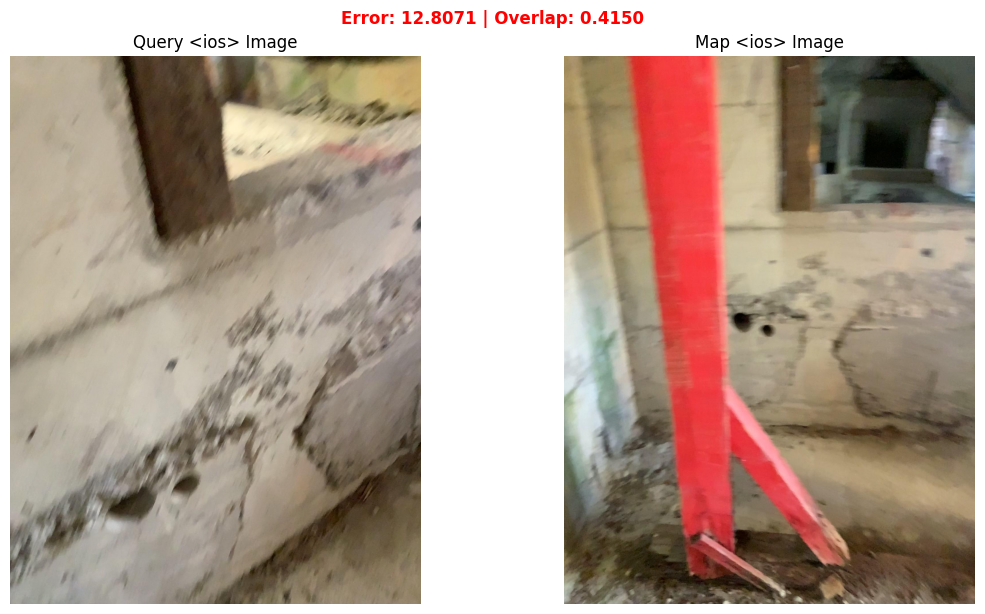

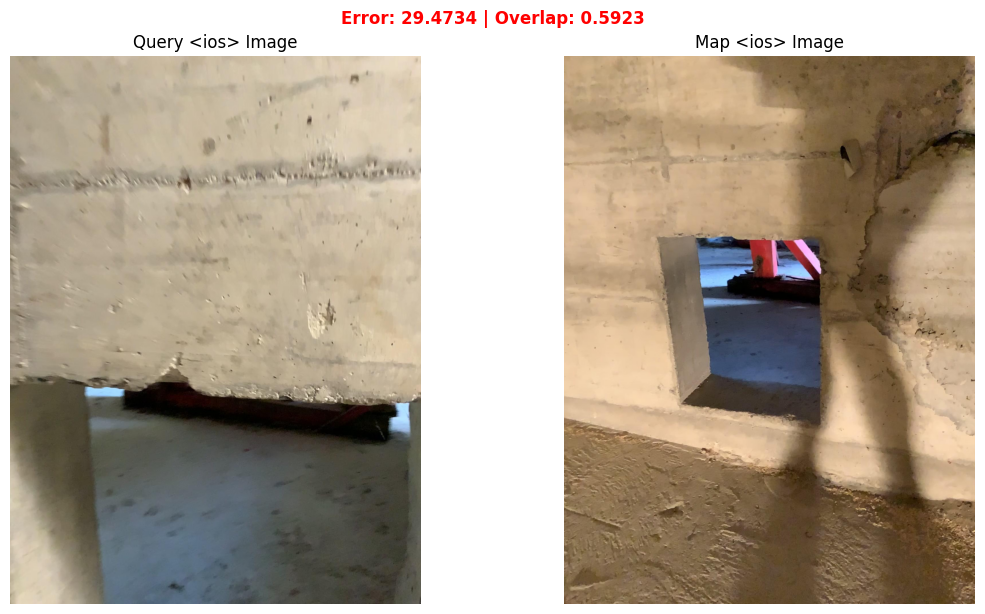

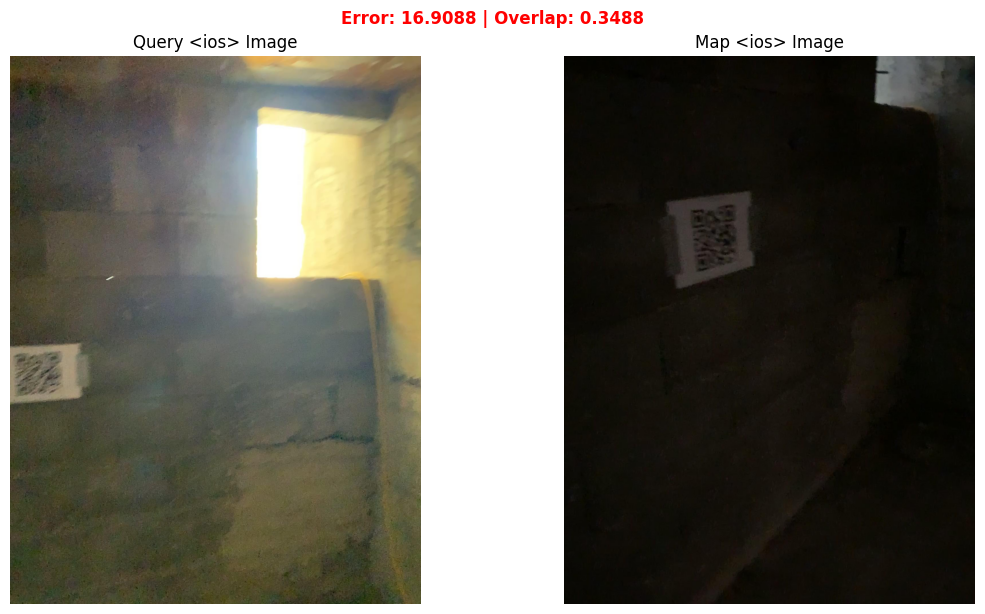

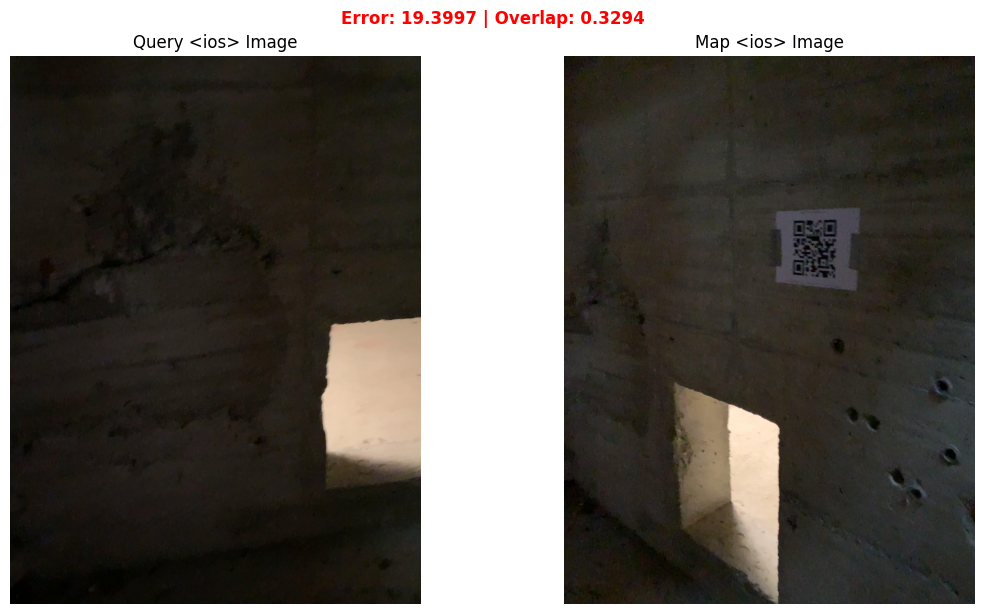

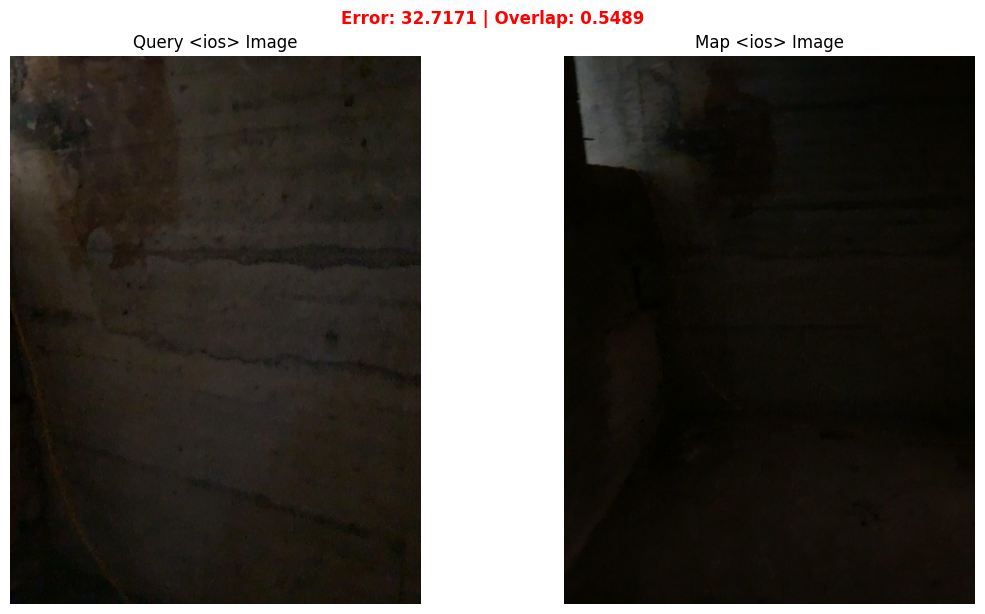

In [21]:
capture = '/home/long/Workspace/crocodl-benchmark/capture'
query_device = 'ios'
map_device = 'ios'
group = 'keep'
PAIRS_PATH = f"estimate_pose/{query_device}_query/{map_device}_map/{group}_trimesh_depth{depth}_thresh{threshold}_pairs.txt"

pairs = load_pairs(PAIRS_PATH, 5)
for pair in pairs:
    show_img_pair(pair, capture, query_device, map_device, metrics=[("Error", 2), ("Overlap", 4)])